In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import numpy as np
from torch.utils.data import Dataset, DataLoader
from typing import List, Tuple, Dict
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


In [2]:
pl.seed_everything(12345)

Global seed set to 12345


12345

In [3]:
# -1 denotes missing value
node_config = {
    "node1": {
        "param1": [0, 10],
        "param2": [5.0, 8.0],
        "param3": [0, 4],
    },
    "node2": {
        "param1": [9.0, 20.0],
        "param2": [0, 1],
        "param3": [0, 100],
        "param4": [0, 3],
        "param5": [0.0, 1.0],
    },
    "node3": {
        "param1": [0, 1],
        "param2": [1, 20],
    },
    "node4": {
        "param1": [0, 4],
        "param2": [-1, 10.0],
        "param3": [-1, 100.0],
        "param4": [0.0, 1.0],
        "param5": [20, 60],
    },
    "node5": {
        "param1": [0.0, 1.0],
        "param2": [0.0, 1.0],
        "param3": [0, 1],
        "param4": [-1, 4],
    },
}

In [4]:
class NodeDataset(Dataset):
    def __init__(self, config: Dict[str, Dict], length: int = int(1e5), missing_rate=1e-2) -> None:
        super().__init__()
        self.config = config
        self.length = length
        self.missing_rate = missing_rate
    
    def generate(self) -> Dict[str, torch.Tensor]:
        sample = {}
        for key, params_config in self.config.items():
            node = []
            for param_config in params_config.values():
                can_be_missing = param_config[0] == -1
                if can_be_missing and np.random.rand() < self.missing_rate:
                    node.append(-1)
                    continue
                low = 0 if can_be_missing else param_config[0]
                high = param_config[-1]
                sample_fn = np.random.uniform if isinstance(param_config[-1], float) else np.random.randint
                node.append(sample_fn(low=low, high=high))
            sample[key] = torch.Tensor(node)
        return sample
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, *args, **kwargs) ->  Dict[str, torch.Tensor]:
        return self.generate()

In [5]:
class Encoder(nn.Module):
    def __init__(self, n_input: int, n_hidden: List[int], n_output: int):
        super().__init__()
        assert len(n_hidden) > 0
        self.model = nn.Sequential()
        self.model.append(nn.Linear(n_input, n_hidden[0]))
        self.model.append(nn.ReLU())
        for i in range(1, len(n_hidden)):
             self.model.append(nn.Linear(n_hidden[i-1], n_hidden[i]))
             self.model.append(nn.ReLU())
        self.model.append(nn.Linear(n_hidden[-1], n_output))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

class Decoder(nn.Module):
    def __init__(self, n_input: int, n_hidden: List[int], n_output: int):
        super().__init__()
        assert len(n_hidden) > 0
        self.model = nn.Sequential()
        self.model.append(nn.Linear(n_input, n_hidden[0]))
        self.model.append(nn.ReLU())
        for i in range(1, len(n_hidden)):
             self.model.append(nn.Linear(n_hidden[i-1], n_hidden[i]))
             self.model.append(nn.ReLU())
        self.model.append(nn.Linear(n_hidden[-1], n_output))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

class AutoEncoder(nn.Module):
    def __init__(self, n_input, n_hidden: List[int], n_embedding: int=8):
        super().__init__()
        self.encoder = Encoder(n_input, n_hidden, n_embedding)
        self.decoder = Decoder(n_embedding, n_hidden, n_input)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        embedding = self.encoder(x)
        reconstruction = self.decoder(embedding)
        return embedding, reconstruction

In [6]:
class JoinedAutoEncoders(pl.LightningModule):
    def __init__(self, autoencoders: Dict[str, nn.Module]):
        super().__init__()
        self.autoencoders = nn.ModuleDict(autoencoders)
    
    def reconstruction_loss(self, pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        loss = F.mse_loss(pred, target)
        return loss
    
    def embedding_simmilarity_loss(self, embeddings: List[torch.Tensor]) -> torch.Tensor:
        losses = []
        for i in range(len(embeddings)):
            anchor = embeddings[i]
            shuffled_indices = np.arange(len(anchor))
            np.random.shuffle(shuffled_indices)
            positives = anchor[shuffled_indices]
            for j in range(len(embeddings)):
                if j != i:
                    negatives = embeddings[j]
                    losses.append(F.triplet_margin_loss(anchor, positives, negatives))
        loss = torch.mean(torch.stack(losses))
        return loss 

    def training_step(self, x: Dict[str, torch.Tensor], *args, **kwargs) -> torch.Tensor:
        embeddings = []
        reconstruction_losses = []
        for key in x:
            data = x[key]
            embedding, reconstruction = self.autoencoders[key](data)
            reconstruction_losses.append(self.reconstruction_loss(reconstruction, data))
            embeddings.append(embedding)
        reconstruction_loss = torch.mean(torch.stack(reconstruction_losses))
        embedding_simmilarity_loss = self.embedding_simmilarity_loss(embeddings)
        loss = reconstruction_loss + embedding_simmilarity_loss
        self.log("train/reconstruction_loss", reconstruction_loss)
        self.log("train/embedding_simmilarity_loss", embedding_simmilarity_loss)
        self.log("train/loss", loss)
        return loss
    
    def validation_step(self, x: Dict[str, torch.Tensor], *args, **kwargs):
        with torch.no_grad():
            reconstruction_losses = []
            for key in x:
                data = x[key]
                _, reconstruction = self.autoencoders[key](data)
                reconstruction_losses.append(self.reconstruction_loss(reconstruction, data))
        reconstruction_loss = torch.mean(torch.stack(reconstruction_losses))
        self.log("val/reconstruction_loss", reconstruction_loss)

    def configure_optimizers(self) -> optim.Optimizer:
            optimizer = optim.AdamW(self.parameters(), lr=1e-3, weight_decay=1e-5)
            return optimizer

In [7]:
BATCH_SIZE = 1024

N_EMBEDDING = 8
N_HIDDEN = [8,8]
autoencoders = {}
for key in node_config:
    n_input = len(node_config[key])
    autoencoder = AutoEncoder(n_input, N_HIDDEN, N_EMBEDDING)
    autoencoders[key] = autoencoder

model = JoinedAutoEncoders(autoencoders)

train_ds = NodeDataset(node_config)
val_ds = NodeDataset(node_config)

train_dl = DataLoader(train_ds, BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, BATCH_SIZE, shuffle=False)

logger = TensorBoardLogger("experiments")
early_stopping_callback = EarlyStopping("val/reconstruction_loss")
model_checkpoint_callback = ModelCheckpoint()
trainer = pl.Trainer(
    max_epochs=1000,
    logger=logger,
    callbacks=[early_stopping_callback, model_checkpoint_callback]
)

In [8]:
trainer.fit(model, train_dl, val_dl)

In [12]:
d = torch.load(r"C:\Users\chern\python_projects\MetaFEDOT\experiments\lightning_logs\version_0\checkpoints\epoch=31-step=3136.ckpt")

In [14]:
model.load_state_dict(d["state_dict"])

<All keys matched successfully>

In [15]:
sample = next(iter(val_dl))

In [23]:
embeddings = {}
reconstructions = {}

with torch.no_grad():
    for key in sample:
        data = sample[key]
        embedding, reconstruction = model.autoencoders[key](data)
        embeddings[key] = embedding
        reconstructions[key] = reconstruction

In [52]:
transformed = TSNE(2, init="random", random_state=3).fit_transform(torch.vstack(list(embeddings.values())))

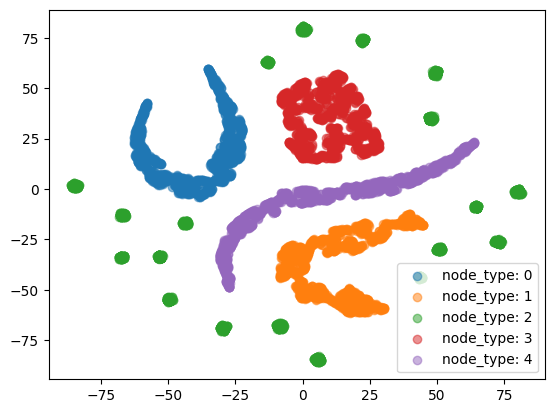

In [56]:
for i, e in enumerate(transformed.reshape(5, -1, 2)):
    plt.scatter(*e.T, alpha=0.5, label=f"node_type: {i}")
plt.legend()